In [1]:
trial_number_ml = "004"
random_state_init = 444

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model2_rna_prot_bin
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model2_rna_prot_bin


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model2_files = ['../../data_for_ml/ml_datasets_set2/model2_rna_bin_protein_bin/data.pkl']

# Load datasets
model2_df = load_and_concatenate_datasets(model2_files)

# Preprocess datasets
X2, y2 = preprocess_data(model2_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X2, y2)

# Output shapes
print(f"Model 2 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 2 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 16:12:21,918] A new study created in memory with name: no-name-54db2a22-83c8-4e3c-b214-6af884951870


[I 2024-05-01 16:13:26,120] Trial 3 finished with value: 0.8182981338697062 and parameters: {'n_estimators': 427, 'max_depth': 31, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 3 with value: 0.8182981338697062.


[I 2024-05-01 16:14:11,937] Trial 0 finished with value: 0.8657970926157315 and parameters: {'n_estimators': 509, 'max_depth': 65, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8657970926157315.


[I 2024-05-01 16:14:17,336] Trial 1 finished with value: 0.8278629405012239 and parameters: {'n_estimators': 788, 'max_depth': 62, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.8657970926157315.


[I 2024-05-01 16:14:50,713] Trial 4 finished with value: 0.8230797752923131 and parameters: {'n_estimators': 625, 'max_depth': 37, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.8657970926157315.


[I 2024-05-01 16:14:51,639] Trial 5 finished with value: 0.8571866841394163 and parameters: {'n_estimators': 257, 'max_depth': 63, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.8657970926157315.


[I 2024-05-01 16:15:28,227] Trial 6 finished with value: 0.8335999959365697 and parameters: {'n_estimators': 418, 'max_depth': 29, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8657970926157315.


[I 2024-05-01 16:15:36,231] Trial 2 finished with value: 0.8651596420118043 and parameters: {'n_estimators': 960, 'max_depth': 58, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8657970926157315.


[I 2024-05-01 16:15:40,687] Trial 9 pruned. 


[I 2024-05-01 16:15:47,489] Trial 10 pruned. 


[I 2024-05-01 16:15:48,382] Trial 7 finished with value: 0.866749459055862 and parameters: {'n_estimators': 329, 'max_depth': 90, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 7 with value: 0.866749459055862.


[I 2024-05-01 16:15:49,998] Trial 8 pruned. 


[I 2024-05-01 16:15:51,383] Trial 13 pruned. 


[I 2024-05-01 16:16:02,075] Trial 11 pruned. 


[I 2024-05-01 16:16:07,795] Trial 12 pruned. 


[I 2024-05-01 16:16:16,536] Trial 14 finished with value: 0.8705767023232662 and parameters: {'n_estimators': 111, 'max_depth': 86, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8705767023232662.


[I 2024-05-01 16:16:52,520] Trial 16 finished with value: 0.8708936498745417 and parameters: {'n_estimators': 224, 'max_depth': 86, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 16 with value: 0.8708936498745417.


[I 2024-05-01 16:16:57,411] Trial 18 finished with value: 0.8728100651164681 and parameters: {'n_estimators': 177, 'max_depth': 97, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.8728100651164681.


[I 2024-05-01 16:17:06,325] Trial 20 pruned. 


[I 2024-05-01 16:17:13,094] Trial 17 finished with value: 0.870575178536962 and parameters: {'n_estimators': 290, 'max_depth': 83, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 18 with value: 0.8728100651164681.


[I 2024-05-01 16:17:21,949] Trial 22 pruned. 


[I 2024-05-01 16:17:27,248] Trial 19 finished with value: 0.8769583193652922 and parameters: {'n_estimators': 134, 'max_depth': 79, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.8769583193652922.


[I 2024-05-01 16:17:50,931] Trial 23 pruned. 


[I 2024-05-01 16:18:17,882] Trial 24 finished with value: 0.8680299474801654 and parameters: {'n_estimators': 201, 'max_depth': 100, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.8769583193652922.


[I 2024-05-01 16:18:21,136] Trial 21 finished with value: 0.8782286492142342 and parameters: {'n_estimators': 286, 'max_depth': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 21 with value: 0.8782286492142342.


[I 2024-05-01 16:18:34,470] Trial 15 finished with value: 0.8734459919340912 and parameters: {'n_estimators': 692, 'max_depth': 92, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 21 with value: 0.8782286492142342.


[I 2024-05-01 16:18:42,587] Trial 25 finished with value: 0.8686633346539482 and parameters: {'n_estimators': 200, 'max_depth': 98, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 21 with value: 0.8782286492142342.


[I 2024-05-01 16:19:05,792] Trial 28 pruned. 


[I 2024-05-01 16:19:13,803] Trial 29 pruned. 


[I 2024-05-01 16:19:27,549] Trial 26 finished with value: 0.8801415089547842 and parameters: {'n_estimators': 273, 'max_depth': 72, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8801415089547842.


[I 2024-05-01 16:19:43,773] Trial 32 pruned. 


[I 2024-05-01 16:19:43,920] Trial 27 finished with value: 0.8702567071993824 and parameters: {'n_estimators': 329, 'max_depth': 94, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8801415089547842.


[I 2024-05-01 16:19:49,189] Trial 30 pruned. 


[I 2024-05-01 16:20:35,689] Trial 31 pruned. 


[I 2024-05-01 16:20:57,438] Trial 33 finished with value: 0.8702567071993824 and parameters: {'n_estimators': 375, 'max_depth': 67, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8801415089547842.


[I 2024-05-01 16:21:36,167] Trial 34 finished with value: 0.8782301730005383 and parameters: {'n_estimators': 585, 'max_depth': 81, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8801415089547842.


[I 2024-05-01 16:21:54,865] Trial 38 pruned. 


[I 2024-05-01 16:22:32,896] Trial 35 finished with value: 0.8779106858054228 and parameters: {'n_estimators': 869, 'max_depth': 83, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8801415089547842.


[I 2024-05-01 16:23:05,059] Trial 40 pruned. 


[I 2024-05-01 16:23:12,778] Trial 36 finished with value: 0.8766332449537277 and parameters: {'n_estimators': 835, 'max_depth': 68, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8801415089547842.


[I 2024-05-01 16:23:41,644] Trial 37 finished with value: 0.8769522242200753 and parameters: {'n_estimators': 861, 'max_depth': 78, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8801415089547842.


[I 2024-05-01 16:23:49,081] Trial 42 pruned. 


[I 2024-05-01 16:24:00,191] Trial 43 pruned. 


[I 2024-05-01 16:24:42,369] Trial 39 finished with value: 0.8779086540903502 and parameters: {'n_estimators': 855, 'max_depth': 58, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8801415089547842.


[I 2024-05-01 16:24:56,724] Trial 45 finished with value: 0.8779096699478866 and parameters: {'n_estimators': 276, 'max_depth': 72, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8801415089547842.


[I 2024-05-01 16:25:05,852] Trial 47 pruned. 


[I 2024-05-01 16:25:23,486] Trial 44 finished with value: 0.8785481364093499 and parameters: {'n_estimators': 463, 'max_depth': 82, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8801415089547842.


[I 2024-05-01 16:25:46,019] Trial 49 pruned. 


[I 2024-05-01 16:25:59,125] Trial 41 finished with value: 0.8772717114151913 and parameters: {'n_estimators': 909, 'max_depth': 57, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8801415089547842.


[I 2024-05-01 16:26:08,735] Trial 46 finished with value: 0.8795020266357845 and parameters: {'n_estimators': 580, 'max_depth': 47, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8801415089547842.


[I 2024-05-01 16:26:12,572] Trial 48 finished with value: 0.8772732352014954 and parameters: {'n_estimators': 578, 'max_depth': 83, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 26 with value: 0.8801415089547842.


Best trial for RandomForestClassifier:
  Value: 0.8801415089547842
  Params: 
    n_estimators: 273
    max_depth: 72
    min_samples_split: 2
    min_samples_leaf: 1
    max_features: sqrt

Best hyperparameters for RandomForestClassifier: {'n_estimators': 273, 'max_depth': 72, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


[I 2024-05-01 16:26:19,462] A new study created in memory with name: no-name-e94e8fab-d218-4ad2-9651-20bbb4f4cc64


RandomForestClassifier accuracy: 0.8688



[I 2024-05-01 16:26:24,073] Trial 0 finished with value: 0.8307296904682087 and parameters: {'n_estimators': 134, 'max_depth': 8, 'learning_rate': 0.16383582059436683, 'min_child_weight': 4, 'subsample': 0.7798940483342371, 'colsample_bytree': 0.5947534163800432, 'gamma': 3.4829037602428414, 'reg_lambda': 0.015083927455052137, 'reg_alpha': 6.2868751946483545}. Best is trial 0 with value: 0.8307296904682087.


[I 2024-05-01 16:26:25,753] Trial 2 finished with value: 0.8629227237172259 and parameters: {'n_estimators': 194, 'max_depth': 10, 'learning_rate': 0.2764422256343616, 'min_child_weight': 3, 'subsample': 0.6339349427732535, 'colsample_bytree': 0.6656603331575645, 'gamma': 2.218705484691985, 'reg_lambda': 2.551349962252391, 'reg_alpha': 0.1878606540971064}. Best is trial 2 with value: 0.8629227237172259.


[I 2024-05-01 16:26:35,376] Trial 1 finished with value: 0.8747198772844097 and parameters: {'n_estimators': 429, 'max_depth': 6, 'learning_rate': 0.05334750643781859, 'min_child_weight': 5, 'subsample': 0.8399188513518486, 'colsample_bytree': 0.5191388820756164, 'gamma': 0.07046817297443608, 'reg_lambda': 2.5304880688419837, 'reg_alpha': 0.06833244206280609}. Best is trial 1 with value: 0.8747198772844097.


[I 2024-05-01 16:26:38,700] Trial 3 finished with value: 0.8616544255833561 and parameters: {'n_estimators': 631, 'max_depth': 9, 'learning_rate': 0.08409932607132528, 'min_child_weight': 5, 'subsample': 0.8426658149066613, 'colsample_bytree': 0.5751307735063546, 'gamma': 0.8524616109537209, 'reg_lambda': 3.1870023504944145, 'reg_alpha': 4.210300525713633}. Best is trial 1 with value: 0.8747198772844097.


[I 2024-05-01 16:26:40,781] Trial 6 finished with value: 0.8587759932547059 and parameters: {'n_estimators': 134, 'max_depth': 9, 'learning_rate': 0.21143317898657105, 'min_child_weight': 8, 'subsample': 0.707269439872497, 'colsample_bytree': 0.7571707043594149, 'gamma': 1.138439201995296, 'reg_lambda': 0.02650830477324055, 'reg_alpha': 3.716002944012275}. Best is trial 1 with value: 0.8747198772844097.


[I 2024-05-01 16:26:41,724] Trial 8 pruned. 


[I 2024-05-01 16:26:42,132] Trial 7 pruned. 


[I 2024-05-01 16:26:42,431] Trial 4 pruned. 


[I 2024-05-01 16:26:42,838] Trial 9 pruned. 


[I 2024-05-01 16:26:43,362] Trial 11 pruned. 


[I 2024-05-01 16:26:43,860] Trial 5 finished with value: 0.8610103719054439 and parameters: {'n_estimators': 590, 'max_depth': 10, 'learning_rate': 0.08262699171341253, 'min_child_weight': 8, 'subsample': 0.6665172296730315, 'colsample_bytree': 0.8577073486051687, 'gamma': 1.5234758223015343, 'reg_lambda': 0.5059552105760086, 'reg_alpha': 0.9774133757686418}. Best is trial 1 with value: 0.8747198772844097.


[I 2024-05-01 16:26:46,275] Trial 10 pruned. 


[I 2024-05-01 16:26:47,227] Trial 12 pruned. 


[I 2024-05-01 16:26:48,108] Trial 15 pruned. 


[I 2024-05-01 16:26:51,578] Trial 16 pruned. 


[I 2024-05-01 16:26:52,488] Trial 13 pruned. 


[I 2024-05-01 16:26:55,364] Trial 19 pruned. 


[I 2024-05-01 16:26:56,259] Trial 14 finished with value: 0.864201180426457 and parameters: {'n_estimators': 299, 'max_depth': 6, 'learning_rate': 0.02325105503547126, 'min_child_weight': 1, 'subsample': 0.5063226111711725, 'colsample_bytree': 0.5000269786563679, 'gamma': 2.4986819886262497, 'reg_lambda': 0.7691878919214333, 'reg_alpha': 0.06555219000420139}. Best is trial 1 with value: 0.8747198772844097.


[I 2024-05-01 16:26:58,254] Trial 20 pruned. 


[I 2024-05-01 16:26:58,756] Trial 21 pruned. 


[I 2024-05-01 16:26:59,796] Trial 23 pruned. 


[I 2024-05-01 16:27:01,070] Trial 22 pruned. 


[I 2024-05-01 16:27:03,835] Trial 18 finished with value: 0.8731249809526712 and parameters: {'n_estimators': 264, 'max_depth': 7, 'learning_rate': 0.22811117949129928, 'min_child_weight': 2, 'subsample': 0.6281564934853389, 'colsample_bytree': 0.7717042906406855, 'gamma': 0.0016540314716055882, 'reg_lambda': 1.6163716702852386, 'reg_alpha': 0.16209961806085463}. Best is trial 1 with value: 0.8747198772844097.


[I 2024-05-01 16:27:09,718] Trial 24 finished with value: 0.8737624315565984 and parameters: {'n_estimators': 218, 'max_depth': 10, 'learning_rate': 0.22633830550824185, 'min_child_weight': 2, 'subsample': 0.6038911060669954, 'colsample_bytree': 0.6409946301615425, 'gamma': 0.5004322956289716, 'reg_lambda': 3.6349046582866285, 'reg_alpha': 0.24419862859287908}. Best is trial 1 with value: 0.8747198772844097.


[I 2024-05-01 16:27:12,842] Trial 25 finished with value: 0.8708931419457736 and parameters: {'n_estimators': 236, 'max_depth': 8, 'learning_rate': 0.19912399269642603, 'min_child_weight': 2, 'subsample': 0.6305739232942988, 'colsample_bytree': 0.5485408587180376, 'gamma': 0.38540291292315754, 'reg_lambda': 3.929887294113501, 'reg_alpha': 0.29932333839648045}. Best is trial 1 with value: 0.8747198772844097.


[I 2024-05-01 16:27:13,144] Trial 17 finished with value: 0.8664299718607463 and parameters: {'n_estimators': 919, 'max_depth': 3, 'learning_rate': 0.2376693619659394, 'min_child_weight': 1, 'subsample': 0.5644672595446782, 'colsample_bytree': 0.8014724835798664, 'gamma': 0.01155904753524295, 'reg_lambda': 1.5193150075927804, 'reg_alpha': 0.09144495720873405}. Best is trial 1 with value: 0.8747198772844097.


[I 2024-05-01 16:27:15,181] Trial 26 finished with value: 0.8747193693556415 and parameters: {'n_estimators': 269, 'max_depth': 8, 'learning_rate': 0.20581319061247932, 'min_child_weight': 1, 'subsample': 0.7432560181806085, 'colsample_bytree': 0.8190472883677244, 'gamma': 0.4687479345470925, 'reg_lambda': 0.30327502938351814, 'reg_alpha': 0.3410677205575293}. Best is trial 1 with value: 0.8747198772844097.


[I 2024-05-01 16:27:19,585] Trial 27 finished with value: 0.8734454840053232 and parameters: {'n_estimators': 229, 'max_depth': 8, 'learning_rate': 0.20901350738387237, 'min_child_weight': 2, 'subsample': 0.7427693009293107, 'colsample_bytree': 0.7908418059278173, 'gamma': 0.4631049387422663, 'reg_lambda': 4.32720563718651, 'reg_alpha': 0.45228547494527}. Best is trial 1 with value: 0.8747198772844097.


[I 2024-05-01 16:27:22,081] Trial 28 finished with value: 0.87631426568738 and parameters: {'n_estimators': 219, 'max_depth': 10, 'learning_rate': 0.2325165002602837, 'min_child_weight': 2, 'subsample': 0.7402642844467752, 'colsample_bytree': 0.7978393418348924, 'gamma': 0.5619086427352575, 'reg_lambda': 9.90265228004552, 'reg_alpha': 0.028794817238236077}. Best is trial 28 with value: 0.87631426568738.


[I 2024-05-01 16:27:22,705] Trial 29 finished with value: 0.8728065096150915 and parameters: {'n_estimators': 211, 'max_depth': 10, 'learning_rate': 0.2461133581382762, 'min_child_weight': 3, 'subsample': 0.7432381912124715, 'colsample_bytree': 0.7633479513497737, 'gamma': 0.5573396761067895, 'reg_lambda': 9.930231322849403, 'reg_alpha': 0.4567001410641126}. Best is trial 28 with value: 0.87631426568738.


[I 2024-05-01 16:27:24,565] Trial 33 pruned. 


[I 2024-05-01 16:27:24,807] Trial 32 pruned. 


[I 2024-05-01 16:27:25,375] Trial 30 finished with value: 0.8763208687613648 and parameters: {'n_estimators': 207, 'max_depth': 10, 'learning_rate': 0.19178623111468568, 'min_child_weight': 3, 'subsample': 0.7387347988087334, 'colsample_bytree': 0.8465326976105254, 'gamma': 0.5799486934688733, 'reg_lambda': 0.2948316039198678, 'reg_alpha': 0.48301193199537557}. Best is trial 30 with value: 0.8763208687613648.


[I 2024-05-01 16:27:26,080] Trial 34 pruned. 


[I 2024-05-01 16:27:30,550] Trial 31 finished with value: 0.8737629394853667 and parameters: {'n_estimators': 326, 'max_depth': 10, 'learning_rate': 0.1921505692042471, 'min_child_weight': 3, 'subsample': 0.856001888910416, 'colsample_bytree': 0.848227206813676, 'gamma': 0.6419580803206619, 'reg_lambda': 0.3599790666939531, 'reg_alpha': 0.035663480548313135}. Best is trial 30 with value: 0.8763208687613648.


[I 2024-05-01 16:27:31,784] Trial 36 finished with value: 0.8801379534534076 and parameters: {'n_estimators': 165, 'max_depth': 10, 'learning_rate': 0.2547800214502449, 'min_child_weight': 3, 'subsample': 0.7828520471472876, 'colsample_bytree': 0.9009344445876597, 'gamma': 0.7324308608013899, 'reg_lambda': 0.3723768234277783, 'reg_alpha': 0.01742520552836744}. Best is trial 36 with value: 0.8801379534534076.


[I 2024-05-01 16:27:32,207] Trial 35 finished with value: 0.880774896128567 and parameters: {'n_estimators': 154, 'max_depth': 10, 'learning_rate': 0.26131244006706, 'min_child_weight': 1, 'subsample': 0.7718813851272944, 'colsample_bytree': 0.7212953634446263, 'gamma': 0.5409235823535186, 'reg_lambda': 5.217799657212025, 'reg_alpha': 0.2739654102839693}. Best is trial 35 with value: 0.880774896128567.


[I 2024-05-01 16:27:33,505] Trial 40 pruned. 


[I 2024-05-01 16:27:34,277] Trial 41 pruned. 


[I 2024-05-01 16:27:34,380] Trial 39 pruned. 


[I 2024-05-01 16:27:35,332] Trial 42 pruned. 


[I 2024-05-01 16:27:35,431] Trial 43 pruned. 


[I 2024-05-01 16:27:37,508] Trial 44 pruned. 


[I 2024-05-01 16:27:37,816] Trial 45 pruned. 


[I 2024-05-01 16:27:40,040] Trial 47 pruned. 


[I 2024-05-01 16:27:41,260] Trial 48 pruned. 


[I 2024-05-01 16:27:41,598] Trial 37 finished with value: 0.8705726388931216 and parameters: {'n_estimators': 452, 'max_depth': 9, 'learning_rate': 0.2651209862346001, 'min_child_weight': 3, 'subsample': 0.8138245632183652, 'colsample_bytree': 0.9041959857700667, 'gamma': 0.30621299827599696, 'reg_lambda': 0.34858291897600396, 'reg_alpha': 0.016507825333067896}. Best is trial 35 with value: 0.880774896128567.


[I 2024-05-01 16:27:46,674] Trial 38 finished with value: 0.8728080334013958 and parameters: {'n_estimators': 758, 'max_depth': 9, 'learning_rate': 0.13255877482848707, 'min_child_weight': 5, 'subsample': 0.815402749228599, 'colsample_bytree': 0.7170115970588504, 'gamma': 1.367152225733038, 'reg_lambda': 0.10612428525886916, 'reg_alpha': 0.017965257126521438}. Best is trial 35 with value: 0.880774896128567.


[I 2024-05-01 16:27:47,932] Trial 46 finished with value: 0.8756757992259165 and parameters: {'n_estimators': 203, 'max_depth': 9, 'learning_rate': 0.24750880887449975, 'min_child_weight': 4, 'subsample': 0.6722644543444806, 'colsample_bytree': 0.741955143463143, 'gamma': 0.29649188075952493, 'reg_lambda': 0.1881389015498369, 'reg_alpha': 0.04875264504645508}. Best is trial 35 with value: 0.880774896128567.


[I 2024-05-01 16:27:57,288] Trial 49 finished with value: 0.8743983583742218 and parameters: {'n_estimators': 712, 'max_depth': 10, 'learning_rate': 0.27604373816226735, 'min_child_weight': 2, 'subsample': 0.7692214247128538, 'colsample_bytree': 0.7390664188512114, 'gamma': 0.9518966723780857, 'reg_lambda': 1.077866029185715, 'reg_alpha': 0.6494466870747863}. Best is trial 35 with value: 0.880774896128567.


Best trial for XGBClassifier:
  Value: 0.880774896128567
  Params: 
    n_estimators: 154
    max_depth: 10
    learning_rate: 0.26131244006706
    min_child_weight: 1
    subsample: 0.7718813851272944
    colsample_bytree: 0.7212953634446263
    gamma: 0.5409235823535186
    reg_lambda: 5.217799657212025
    reg_alpha: 0.2739654102839693

Best hyperparameters for XGBClassifier: {'n_estimators': 154, 'max_depth': 10, 'learning_rate': 0.26131244006706, 'min_child_weight': 1, 'subsample': 0.7718813851272944, 'colsample_bytree': 0.7212953634446263, 'gamma': 0.5409235823535186, 'reg_lambda': 5.217799657212025, 'reg_alpha': 0.2739654102839693}


[I 2024-05-01 16:29:07,072] A new study created in memory with name: no-name-0faea7a1-dae3-4161-b121-314718e8a50d


XGBClassifier accuracy: 0.8713



[I 2024-05-01 16:29:08,002] Trial 2 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 42, 'max_depth': 6, 'learning_rate': 0.24807136482676548, 'n_estimators': 651, 'min_child_weight': 0.002245590603397026, 'min_child_samples': 1442, 'subsample': 0.9112956629999789, 'colsample_bytree': 0.8007034790278046, 'reg_alpha': 0.08875726210728507, 'reg_lambda': 0.042000140678341055}. Best is trial 2 with value: 0.4995215311004785.


[I 2024-05-01 16:29:08,069] Trial 0 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 81, 'max_depth': 3, 'learning_rate': 0.3992564702282578, 'n_estimators': 736, 'min_child_weight': 0.0308225394523789, 'min_child_samples': 1475, 'subsample': 0.8164825629205034, 'colsample_bytree': 0.8771504532533995, 'reg_alpha': 0.0019592819769530846, 'reg_lambda': 0.0018079629670601836}. Best is trial 2 with value: 0.4995215311004785.


[I 2024-05-01 16:29:08,906] Trial 5 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 45, 'max_depth': 8, 'learning_rate': 0.44897753078987945, 'n_estimators': 533, 'min_child_weight': 0.004814247752236115, 'min_child_samples': 1717, 'subsample': 0.8585586239679854, 'colsample_bytree': 0.8278862192829719, 'reg_alpha': 2.687303666419733e-10, 'reg_lambda': 3.972783877720857e-05}. Best is trial 2 with value: 0.4995215311004785.


[I 2024-05-01 16:29:09,354] Trial 3 finished with value: 0.6566782474425786 and parameters: {'boosting_type': 'goss', 'num_leaves': 60, 'max_depth': 10, 'learning_rate': 0.3899296178271006, 'n_estimators': 600, 'min_child_weight': 0.029363130748647097, 'min_child_samples': 770, 'subsample': 0.8654995729460503, 'colsample_bytree': 0.8565951168043697, 'reg_alpha': 0.26634614286765235, 'reg_lambda': 5.259347402925112e-10}. Best is trial 3 with value: 0.6566782474425786.


[I 2024-05-01 16:29:09,552] Trial 6 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 99, 'max_depth': 6, 'learning_rate': 0.49526818841452, 'n_estimators': 321, 'min_child_weight': 0.0010542354058498387, 'min_child_samples': 1506, 'subsample': 0.9103354680427828, 'colsample_bytree': 0.8958554091722486, 'reg_alpha': 0.09880647167899538, 'reg_lambda': 0.44283581784301407}. Best is trial 3 with value: 0.6566782474425786.


[I 2024-05-01 16:29:10,407] Trial 7 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 88, 'max_depth': -1, 'learning_rate': 0.07792595759033381, 'n_estimators': 971, 'min_child_weight': 0.004676695098117042, 'min_child_samples': 1531, 'subsample': 0.945973955973351, 'colsample_bytree': 0.8401812976944565, 'reg_alpha': 0.33090218572998276, 'reg_lambda': 1.6409637779666212e-05}. Best is trial 3 with value: 0.6566782474425786.


[I 2024-05-01 16:29:10,818] Trial 4 finished with value: 0.664325115045866 and parameters: {'boosting_type': 'goss', 'num_leaves': 38, 'max_depth': 3, 'learning_rate': 0.3241738383077805, 'n_estimators': 902, 'min_child_weight': 0.0024104724154260485, 'min_child_samples': 995, 'subsample': 0.8055849732281252, 'colsample_bytree': 0.8298895455541015, 'reg_alpha': 3.880948643560352e-10, 'reg_lambda': 0.2347558444403889}. Best is trial 4 with value: 0.664325115045866.


[I 2024-05-01 16:29:11,004] Trial 9 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'goss', 'num_leaves': 81, 'max_depth': 1, 'learning_rate': 0.06697615164766575, 'n_estimators': 391, 'min_child_weight': 0.0024590279369509373, 'min_child_samples': 1815, 'subsample': 0.9107024025420741, 'colsample_bytree': 0.9649483487196568, 'reg_alpha': 3.920337052948418e-06, 'reg_lambda': 0.0003611035174916239}. Best is trial 4 with value: 0.664325115045866.


[I 2024-05-01 16:29:14,955] Trial 8 finished with value: 0.8489069372911142 and parameters: {'boosting_type': 'dart', 'num_leaves': 90, 'max_depth': 14, 'learning_rate': 0.08425875078258313, 'n_estimators': 102, 'min_child_weight': 0.04174999154553649, 'min_child_samples': 62, 'subsample': 0.8414305467718117, 'colsample_bytree': 0.9243925965095097, 'reg_alpha': 0.029655537199728608, 'reg_lambda': 0.0003585019042029709}. Best is trial 8 with value: 0.8489069372911142.


[I 2024-05-01 16:29:21,246] Trial 12 finished with value: 0.6646451101697498 and parameters: {'boosting_type': 'dart', 'num_leaves': 33, 'max_depth': 0, 'learning_rate': 0.2763816756751836, 'n_estimators': 460, 'min_child_weight': 0.0012615210202627657, 'min_child_samples': 1095, 'subsample': 0.8293846344554241, 'colsample_bytree': 0.8423649839152286, 'reg_alpha': 2.2393258092468526e-08, 'reg_lambda': 3.3365579376663647e-07}. Best is trial 8 with value: 0.8489069372911142.


[I 2024-05-01 16:29:22,481] Trial 10 finished with value: 0.7076763274718354 and parameters: {'boosting_type': 'dart', 'num_leaves': 77, 'max_depth': 9, 'learning_rate': 0.13343365667757875, 'n_estimators': 606, 'min_child_weight': 0.013626015539035412, 'min_child_samples': 723, 'subsample': 0.9019954438867508, 'colsample_bytree': 0.9011656153782786, 'reg_alpha': 8.392467482752658e-07, 'reg_lambda': 0.0007782726971964069}. Best is trial 8 with value: 0.8489069372911142.


[I 2024-05-01 16:29:24,717] Trial 14 finished with value: 0.851452676276679 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'max_depth': 15, 'learning_rate': 0.15654113818906212, 'n_estimators': 100, 'min_child_weight': 0.09805974238303317, 'min_child_samples': 122, 'subsample': 0.9785547488820862, 'colsample_bytree': 0.9392854041566728, 'reg_alpha': 3.541517327323527e-05, 'reg_lambda': 8.79811263544129e-08}. Best is trial 14 with value: 0.851452676276679.


[I 2024-05-01 16:29:27,087] Trial 1 pruned. 


[I 2024-05-01 16:29:27,156] Trial 11 pruned. 


[I 2024-05-01 16:29:27,348] Trial 13 finished with value: 0.8680248681924846 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'max_depth': 15, 'learning_rate': 0.1491962804043563, 'n_estimators': 102, 'min_child_weight': 0.0925266358002835, 'min_child_samples': 34, 'subsample': 0.9894314571449768, 'colsample_bytree': 0.9475970680616215, 'reg_alpha': 0.00020804830118908353, 'reg_lambda': 2.473426861474588e-07}. Best is trial 13 with value: 0.8680248681924846.


[I 2024-05-01 16:29:28,698] Trial 17 finished with value: 0.8310476538770203 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'max_depth': 15, 'learning_rate': 0.17458414228972235, 'n_estimators': 103, 'min_child_weight': 0.09887413248548693, 'min_child_samples': 211, 'subsample': 0.9939901228809442, 'colsample_bytree': 0.9924366494118286, 'reg_alpha': 0.0006396686101399474, 'reg_lambda': 1.8616429889282786e-07}. Best is trial 13 with value: 0.8680248681924846.


[I 2024-05-01 16:29:30,561] Trial 19 finished with value: 0.7213817694206565 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'max_depth': 12, 'learning_rate': 0.0034041233703245855, 'n_estimators': 248, 'min_child_weight': 0.09783314094826041, 'min_child_samples': 398, 'subsample': 0.9997749584018583, 'colsample_bytree': 0.9498124959843822, 'reg_alpha': 0.00013593504002697558, 'reg_lambda': 2.65928687968655e-07}. Best is trial 13 with value: 0.8680248681924846.


[I 2024-05-01 16:29:30,744] Trial 15 finished with value: 0.8721680431536282 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': 15, 'learning_rate': 0.1859303781757198, 'n_estimators': 105, 'min_child_weight': 0.09434901500755384, 'min_child_samples': 36, 'subsample': 0.9796894389393751, 'colsample_bytree': 0.9480720210484072, 'reg_alpha': 0.0003833770395200099, 'reg_lambda': 1.0331550813564293e-07}. Best is trial 15 with value: 0.8721680431536282.


[I 2024-05-01 16:29:32,156] Trial 16 finished with value: 0.8702572151281505 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'max_depth': 15, 'learning_rate': 0.16001100685556757, 'n_estimators': 120, 'min_child_weight': 0.09359551689765644, 'min_child_samples': 48, 'subsample': 0.9910861147138895, 'colsample_bytree': 0.9329265194625127, 'reg_alpha': 0.0007292180220686449, 'reg_lambda': 1.169798353292061e-07}. Best is trial 15 with value: 0.8721680431536282.


[I 2024-05-01 16:29:32,629] Trial 18 finished with value: 0.8750358089781489 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'max_depth': 15, 'learning_rate': 0.1617689279777213, 'n_estimators': 113, 'min_child_weight': 0.0968951683360366, 'min_child_samples': 42, 'subsample': 0.9978162291758836, 'colsample_bytree': 0.9984688092180091, 'reg_alpha': 0.0002459869701587139, 'reg_lambda': 1.7277130403552657e-07}. Best is trial 18 with value: 0.8750358089781489.


[I 2024-05-01 16:29:32,746] Trial 21 finished with value: 0.8007679882973211 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': 12, 'learning_rate': 0.2123563584727599, 'n_estimators': 230, 'min_child_weight': 0.051722884446691306, 'min_child_samples': 412, 'subsample': 0.9400158278819498, 'colsample_bytree': 0.985502363085, 'reg_alpha': 0.003929719496443184, 'reg_lambda': 6.384688980223075e-09}. Best is trial 18 with value: 0.8750358089781489.


[I 2024-05-01 16:29:32,946] Trial 20 finished with value: 0.8026803401091029 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'max_depth': 12, 'learning_rate': 0.19545724753267943, 'n_estimators': 285, 'min_child_weight': 0.046793427848025336, 'min_child_samples': 416, 'subsample': 0.9548802854041859, 'colsample_bytree': 0.989643748546697, 'reg_alpha': 4.5317433953932765e-05, 'reg_lambda': 1.305215374764874e-08}. Best is trial 18 with value: 0.8750358089781489.


[I 2024-05-01 16:29:34,767] Trial 22 finished with value: 0.8020449212202481 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'max_depth': 12, 'learning_rate': 0.2175593262562435, 'n_estimators': 239, 'min_child_weight': 0.050557203514493554, 'min_child_samples': 411, 'subsample': 0.9485226575695155, 'colsample_bytree': 0.9935582524262946, 'reg_alpha': 0.011888747219334478, 'reg_lambda': 4.996533953691048e-09}. Best is trial 18 with value: 0.8750358089781489.


[I 2024-05-01 16:29:35,048] Trial 23 finished with value: 0.8033177907130303 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'max_depth': 12, 'learning_rate': 0.243931174029528, 'n_estimators': 215, 'min_child_weight': 0.0457968256728161, 'min_child_samples': 411, 'subsample': 0.9419447524843161, 'colsample_bytree': 0.9861023112736579, 'reg_alpha': 0.006801446600234752, 'reg_lambda': 7.413437145786361e-09}. Best is trial 18 with value: 0.8750358089781489.


[I 2024-05-01 16:29:35,260] Trial 24 finished with value: 0.8214930058208637 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'max_depth': 13, 'learning_rate': 0.19141120209663157, 'n_estimators': 225, 'min_child_weight': 0.051418563924598155, 'min_child_samples': 342, 'subsample': 0.9588682241243374, 'colsample_bytree': 0.9642804317943301, 'reg_alpha': 1.2025622546225929e-05, 'reg_lambda': 1.0411597708135571e-08}. Best is trial 18 with value: 0.8750358089781489.


[I 2024-05-01 16:29:35,771] Trial 28 pruned. 


[I 2024-05-01 16:29:36,006] Trial 25 finished with value: 0.8326481374252076 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'max_depth': 12, 'learning_rate': 0.2422964294680016, 'n_estimators': 196, 'min_child_weight': 0.06212941127229534, 'min_child_samples': 273, 'subsample': 0.9728015278350785, 'colsample_bytree': 0.9673224824434625, 'reg_alpha': 0.005767899212660362, 'reg_lambda': 2.0905271101086756e-06}. Best is trial 18 with value: 0.8750358089781489.


[I 2024-05-01 16:29:36,400] Trial 30 pruned. 


[I 2024-05-01 16:29:37,326] Trial 26 finished with value: 0.8367862330986704 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'max_depth': 13, 'learning_rate': 0.2935682892388497, 'n_estimators': 181, 'min_child_weight': 0.022671119565383358, 'min_child_samples': 251, 'subsample': 0.972168172299281, 'colsample_bytree': 0.9696326421028743, 'reg_alpha': 3.6016245199490158e-06, 'reg_lambda': 1.0671874456952305e-10}. Best is trial 18 with value: 0.8750358089781489.


[I 2024-05-01 16:29:37,560] Trial 27 finished with value: 0.8415714300226537 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': 14, 'learning_rate': 0.3053950696153493, 'n_estimators': 186, 'min_child_weight': 0.024634277911744825, 'min_child_samples': 232, 'subsample': 0.9777521070412507, 'colsample_bytree': 0.9683854271963606, 'reg_alpha': 7.252946234427505e-06, 'reg_lambda': 2.3443203412920825e-06}. Best is trial 18 with value: 0.8750358089781489.


[I 2024-05-01 16:29:38,045] Trial 33 pruned. 


[I 2024-05-01 16:29:38,301] Trial 29 finished with value: 0.8151078332774612 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': 13, 'learning_rate': 0.04616239489479555, 'n_estimators': 174, 'min_child_weight': 0.06825400388773517, 'min_child_samples': 224, 'subsample': 0.9815129479584752, 'colsample_bytree': 0.9639746838452994, 'reg_alpha': 0.0007438411360244867, 'reg_lambda': 2.5327815434585555e-06}. Best is trial 18 with value: 0.8750358089781489.


[I 2024-05-01 16:29:42,191] Trial 31 finished with value: 0.8536829914972724 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': 14, 'learning_rate': 0.11708100164795399, 'n_estimators': 411, 'min_child_weight': 0.02432497078495194, 'min_child_samples': 183, 'subsample': 0.9276899169998235, 'colsample_bytree': 0.9730018995187101, 'reg_alpha': 4.546076516744841e-06, 'reg_lambda': 4.6481988980780775e-08}. Best is trial 18 with value: 0.8750358089781489.


[I 2024-05-01 16:29:43,481] Trial 32 finished with value: 0.8565527890368655 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'max_depth': 10, 'learning_rate': 0.11558982620796328, 'n_estimators': 417, 'min_child_weight': 0.033563301283685745, 'min_child_samples': 154, 'subsample': 0.9300226181455484, 'colsample_bytree': 0.8748922759162044, 'reg_alpha': 0.0012376133858900229, 'reg_lambda': 1.769164600038599e-06}. Best is trial 18 with value: 0.8750358089781489.


[I 2024-05-01 16:29:44,558] Trial 35 finished with value: 0.8744008980180619 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': 15, 'learning_rate': 0.13309718025053702, 'n_estimators': 133, 'min_child_weight': 0.03793118639086186, 'min_child_samples': 60, 'subsample': 0.9916589955070133, 'colsample_bytree': 0.9444396615843369, 'reg_alpha': 0.00013473683484594218, 'reg_lambda': 4.436246979326419e-08}. Best is trial 18 with value: 0.8750358089781489.


[I 2024-05-01 16:29:44,790] Trial 38 pruned. 


[I 2024-05-01 16:29:47,564] Trial 37 finished with value: 0.8721721065837726 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': 15, 'learning_rate': 0.15948151173570693, 'n_estimators': 143, 'min_child_weight': 0.015599142887531184, 'min_child_samples': 73, 'subsample': 0.9931460297342319, 'colsample_bytree': 0.9463966799883249, 'reg_alpha': 0.00011278895282548918, 'reg_lambda': 3.117030070819142e-08}. Best is trial 18 with value: 0.8750358089781489.


[I 2024-05-01 16:29:47,662] Trial 34 finished with value: 0.8737670029155111 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': 15, 'learning_rate': 0.13626807169122543, 'n_estimators': 144, 'min_child_weight': 0.07273404517037883, 'min_child_samples': 25, 'subsample': 0.9929909791767543, 'colsample_bytree': 0.939126326225436, 'reg_alpha': 0.00010548655648654678, 'reg_lambda': 5.482216324066192e-08}. Best is trial 18 with value: 0.8750358089781489.


[I 2024-05-01 16:29:48,092] Trial 41 pruned. 


[I 2024-05-01 16:29:51,106] Trial 36 finished with value: 0.878226617499162 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'max_depth': 15, 'learning_rate': 0.14559876574266417, 'n_estimators': 140, 'min_child_weight': 0.03354663073736216, 'min_child_samples': 25, 'subsample': 0.9928863806825353, 'colsample_bytree': 0.9458413636232054, 'reg_alpha': 0.00015692290873253335, 'reg_lambda': 5.053596249043487e-08}. Best is trial 36 with value: 0.878226617499162.


[I 2024-05-01 16:29:51,113] Trial 39 finished with value: 0.860053942035169 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'max_depth': 4, 'learning_rate': 0.3536009338128355, 'n_estimators': 316, 'min_child_weight': 0.0174184820092466, 'min_child_samples': 24, 'subsample': 0.9647045344721884, 'colsample_bytree': 0.9492739899014337, 'reg_alpha': 0.03162412512214732, 'reg_lambda': 1.4298153763109296e-09}. Best is trial 36 with value: 0.878226617499162.


[I 2024-05-01 16:29:52,930] Trial 40 finished with value: 0.8654730340617032 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 42, 'max_depth': 4, 'learning_rate': 0.21669332420752774, 'n_estimators': 300, 'min_child_weight': 0.01504782219738142, 'min_child_samples': 33, 'subsample': 0.958927555118241, 'colsample_bytree': 0.9527872752798071, 'reg_alpha': 2.9116124808583694e-07, 'reg_lambda': 9.638518378755992e-10}. Best is trial 36 with value: 0.878226617499162.


[I 2024-05-01 16:29:53,888] Trial 44 finished with value: 0.8492223610560854 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 14, 'learning_rate': 0.09824683339482507, 'n_estimators': 162, 'min_child_weight': 0.033200271089035345, 'min_child_samples': 151, 'subsample': 0.9898053087874397, 'colsample_bytree': 0.9179062786854336, 'reg_alpha': 9.738069410822235e-05, 'reg_lambda': 2.6425788718178024e-08}. Best is trial 36 with value: 0.878226617499162.


[I 2024-05-01 16:29:54,260] Trial 46 pruned. 


[I 2024-05-01 16:29:54,342] Trial 43 finished with value: 0.8504992939790125 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 14, 'learning_rate': 0.09750563220150184, 'n_estimators': 154, 'min_child_weight': 0.010330920625531592, 'min_child_samples': 145, 'subsample': 0.9881193495864383, 'colsample_bytree': 0.9182105617596449, 'reg_alpha': 0.00010513301354765654, 'reg_lambda': 2.4476632051947588e-08}. Best is trial 36 with value: 0.878226617499162.


[I 2024-05-01 16:29:56,673] Trial 42 finished with value: 0.8603764768028931 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 11, 'learning_rate': 0.358602697346877, 'n_estimators': 520, 'min_child_weight': 0.009910786343341754, 'min_child_samples': 126, 'subsample': 0.9639393435698903, 'colsample_bytree': 0.917376108176262, 'reg_alpha': 1.7330910237009512e-07, 'reg_lambda': 2.3167483484315814e-09}. Best is trial 36 with value: 0.878226617499162.


[I 2024-05-01 16:29:57,381] Trial 48 pruned. 


[I 2024-05-01 16:29:57,742] Trial 49 pruned. 


[I 2024-05-01 16:29:58,548] Trial 47 finished with value: 0.8552733164700983 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'max_depth': 11, 'learning_rate': 0.07987174340401243, 'n_estimators': 265, 'min_child_weight': 0.03645071979910936, 'min_child_samples': 143, 'subsample': 0.8755441042410002, 'colsample_bytree': 0.904764469890282, 'reg_alpha': 2.69965466266824e-05, 'reg_lambda': 4.4757279963805686e-07}. Best is trial 36 with value: 0.878226617499162.


[I 2024-05-01 16:30:03,855] Trial 45 finished with value: 0.8575087109783726 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': 14, 'learning_rate': 0.09596466602155762, 'n_estimators': 710, 'min_child_weight': 0.03598022090776107, 'min_child_samples': 143, 'subsample': 0.9999378170537605, 'colsample_bytree': 0.9206517046861781, 'reg_alpha': 0.000129516980743807, 'reg_lambda': 5.967252008830576e-07}. Best is trial 36 with value: 0.878226617499162.


Best trial for LGBMClassifier:
  Value: 0.878226617499162
  Params: 
    boosting_type: gbdt
    num_leaves: 65
    max_depth: 15
    learning_rate: 0.14559876574266417
    n_estimators: 140
    min_child_weight: 0.03354663073736216
    min_child_samples: 25
    subsample: 0.9928863806825353
    colsample_bytree: 0.9458413636232054
    reg_alpha: 0.00015692290873253335
    reg_lambda: 5.053596249043487e-08

Best hyperparameters for LGBMClassifier: {'boosting_type': 'gbdt', 'num_leaves': 65, 'max_depth': 15, 'learning_rate': 0.14559876574266417, 'n_estimators': 140, 'min_child_weight': 0.03354663073736216, 'min_child_samples': 25, 'subsample': 0.9928863806825353, 'colsample_bytree': 0.9458413636232054, 'reg_alpha': 0.00015692290873253335, 'reg_lambda': 5.053596249043487e-08}


LGBMClassifier accuracy: 0.8624
LGBMClassifier accuracy: 0.8624



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_004/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

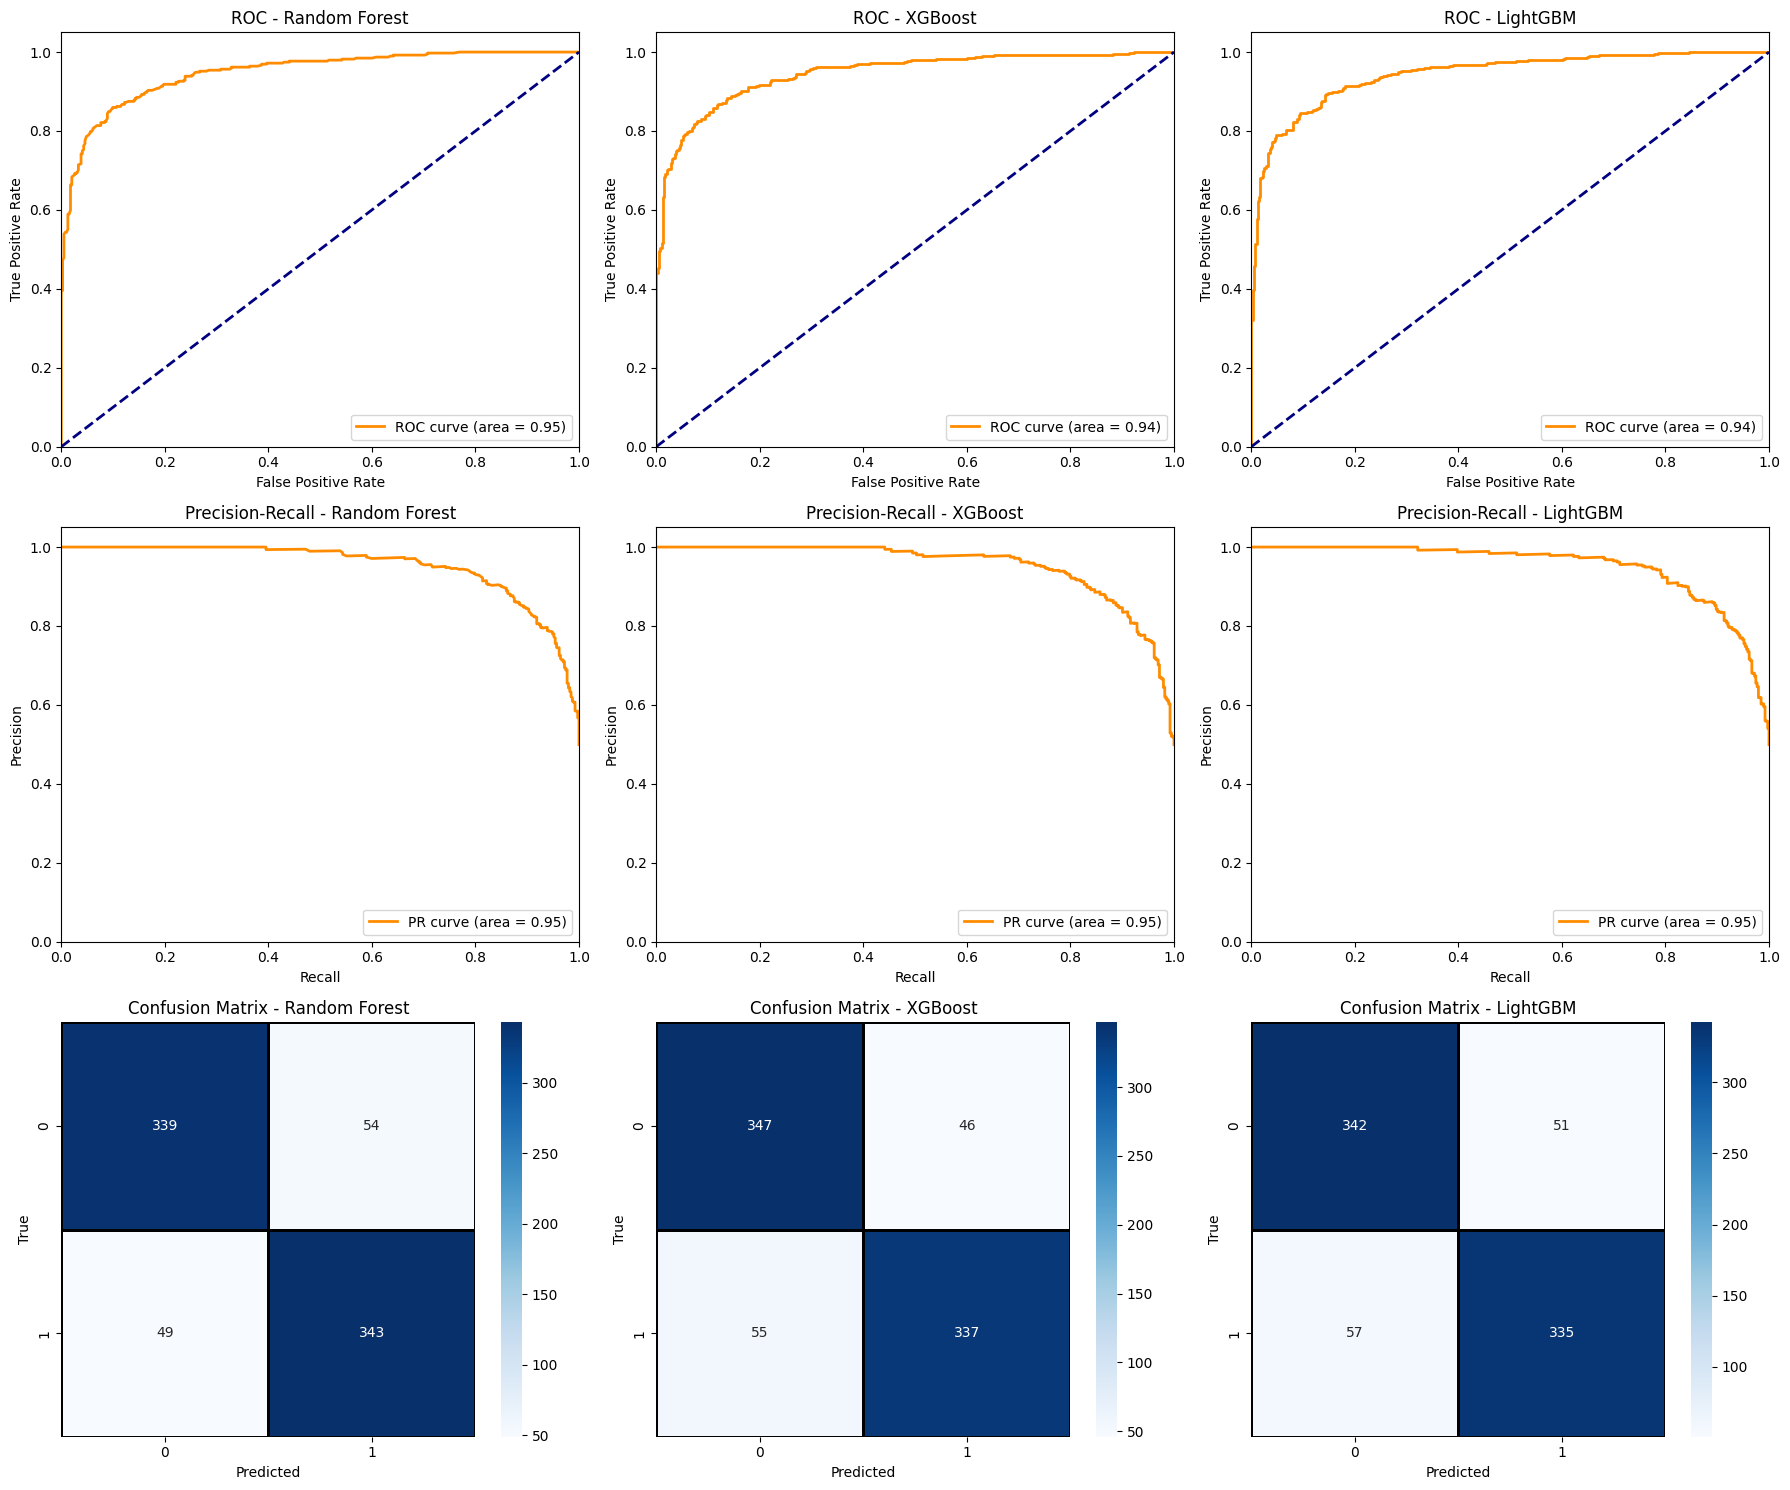

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.8687898089171975, 'Precision': 0.8639798488664987, 'Recall': 0.875, 'F1 Score': 0.8694550063371356, 'ROC AUC': 0.9467239185750637}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.8713375796178344, 'Precision': 0.8798955613577023, 'Recall': 0.8596938775510204, 'F1 Score': 0.8696774193548387, 'ROC AUC': 0.9445785947966973}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.8624203821656051, 'Precision': 0.8678756476683938, 'Recall': 0.8545918367346939, 'F1 Score': 0.8611825192802057, 'ROC AUC': 0.9435205379861868}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.8624203821656051,
 'Precision': 0.8678756476683938,
 'Recall': 0.8545918367346939,
 'F1 Score': 0.8611825192802057,
 'ROC AUC': 0.9435205379861868}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: XGBoost with Accuracy: 0.8713


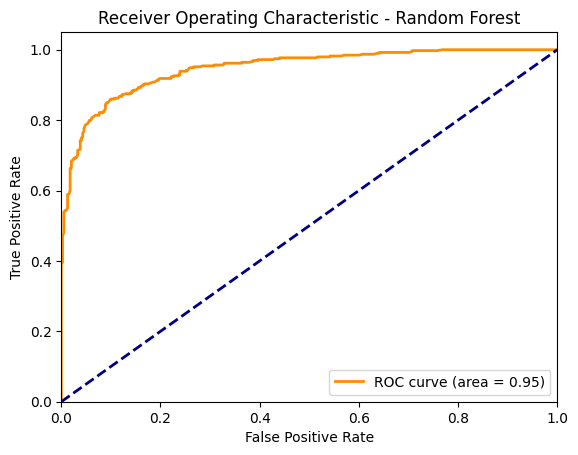

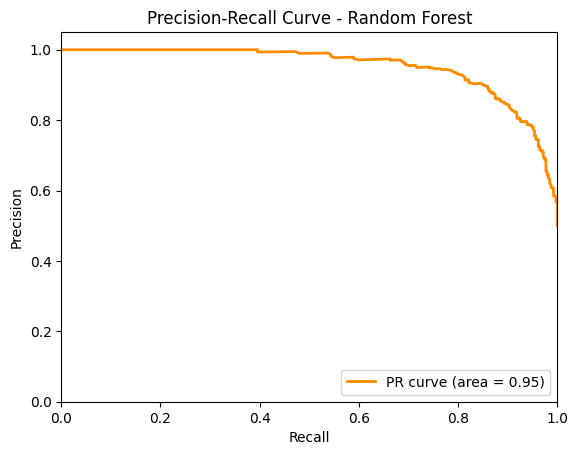

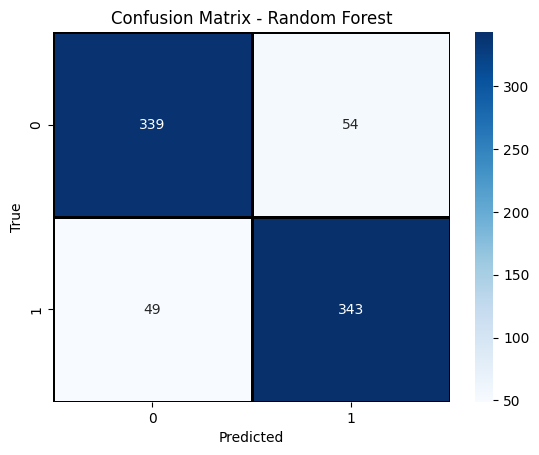

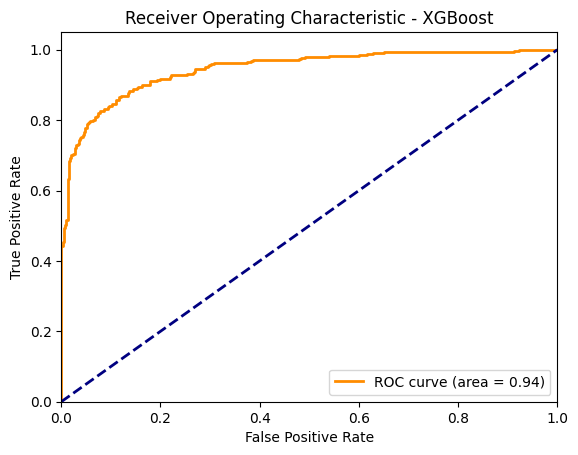

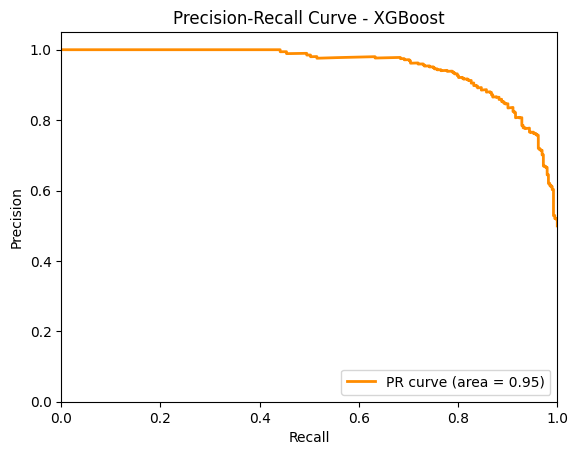

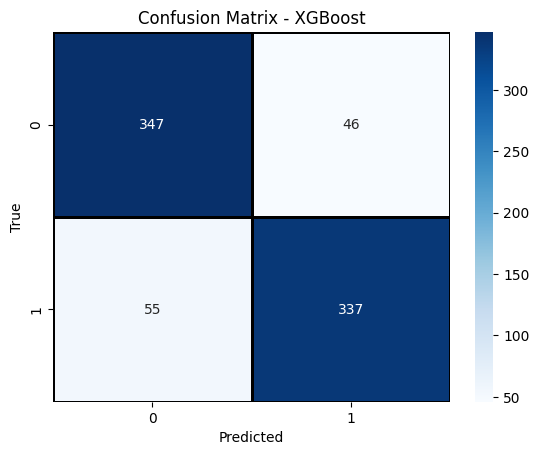

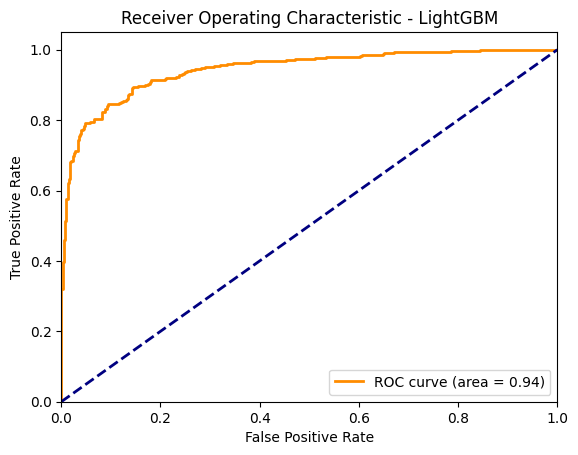

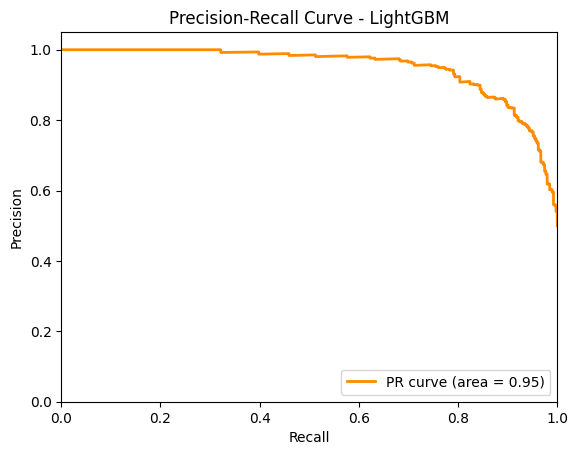

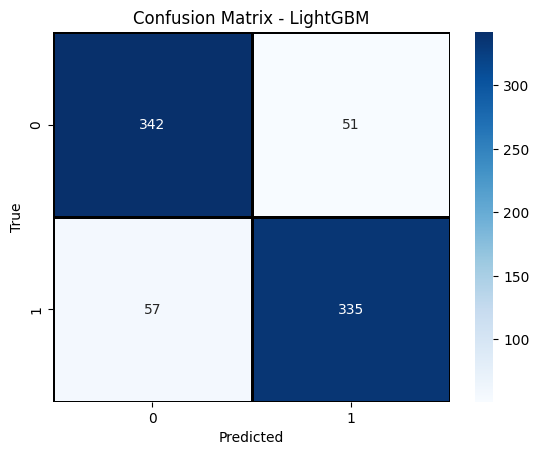

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

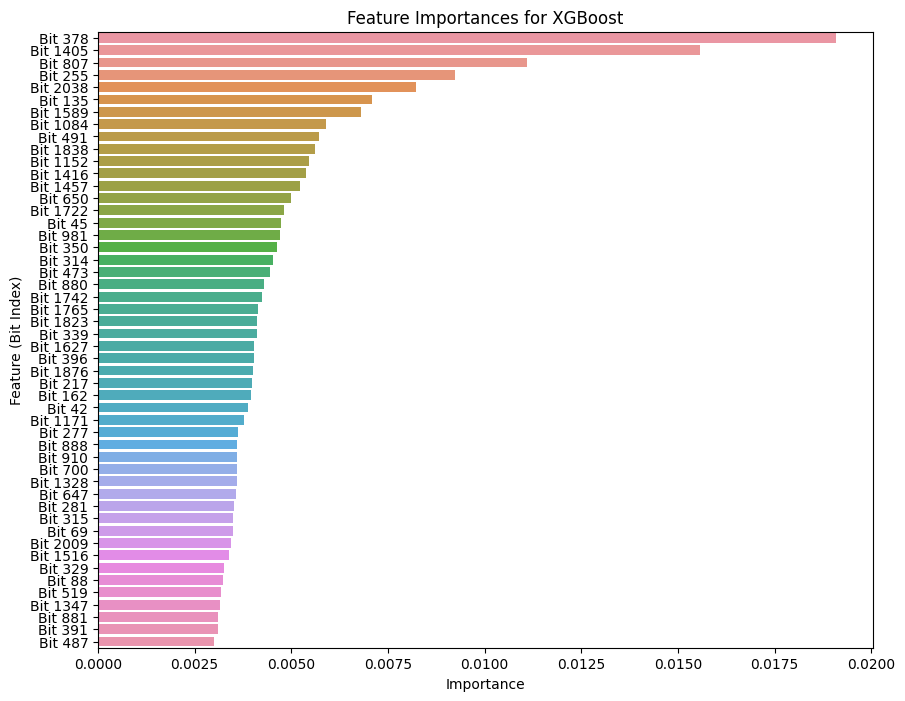

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
